# Investigation of Distributed CNN Training Performances within the context of a Sea Turtle Face Classifier

## CNN Distribution

In [92]:
#run this cell to release the ram that the workers are hoarding. 
#only to be used for debugging memory leeks, there is a fancy way for automatic trimming
import ctypes

def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

client.run(trim_memory)

{'tcp://10.67.22.178:34939': 1,
 'tcp://10.67.22.193:39031': 1,
 'tcp://10.67.22.212:46875': 1,
 'tcp://10.67.22.246:36509': 1,
 'tcp://10.67.22.25:37725': 1,
 'tcp://10.67.22.52:45257': 1}

In [93]:
client.restart()

<Client: 'tcp://10.67.22.233:8786' processes=6 threads=6, memory=20.68 GiB>

In [94]:
# are you on cloud veneto?
onCV = True
if not onCV: 
    !pip install scikit-image

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
import dask.array as da
from pathlib import Path
from dask.distributed import wait
from dask.distributed import Client
import pickle

#from dask_image.imread import imread
from skimage import io, transform
import dask.array as da
import dask.delayed

from tensorflow.keras import models, layers
import tensorflow as tf

import pandas as pd

import re
import os

import time
import timeit

In [96]:
#This will stop the dask worker and scheduler processes on the respective machines
# client.shutdown()

In [97]:
from dask.distributed import Client
if onCV:
    # must run to following command on this jupyter machine to set up cluster.  
    # dask-ssh 10.67.22.{178,193,212,246,25,52} --scheduler 10.67.22.233 --log-directory /home/ubuntu/daskShared_local/logs --ssh-username ubuntu --ssh-private-key /home/ubuntu/.ssh/dasktest
    client = Client('10.67.22.233:8786')
    print('Connecting to CV cluster')

else:
    #after doing docker-compose up the cluster is ready to connect
    client = Client('dask-scheduler:8786')
    print('Connecting to docker cluster')
    #dask-scheduler is an alias for the ip address of the scheduler. I believe it is set up in the image of the jupyter notebook machine. 

client

Connecting to CV cluster


<Client: 'tcp://10.67.22.233:8786' processes=6 threads=6, memory=20.68 GiB>

In [98]:
# # # This cell is used to run commands on all of the workers with parameko ssh
# import paramiko

#scheduler_ip = '10.67.22.233'
# workers_ip = ['10.67.22.52','10.67.22.178','10.67.22.25','10.67.22.246','10.67.22.193','10.67.22.212']
# # all_ip = ['10.67.22.233','10.67.22.52','10.67.22.178','10.67.22.25','10.67.22.246','10.67.22.193','10.67.22.212']


# def ssh_cmd(hostname, cmd_list):
#    k = paramiko.RSAKey.from_private_key_file("/home/ubuntu/.ssh/dasktest")
#    c = paramiko.SSHClient()
#    c.load_host_keys(filename="/home/ubuntu/.ssh/known_hosts")
#    c.set_missing_host_key_policy(paramiko.AutoAddPolicy())
#    c.connect(hostname = hostname, username = "ubuntu", pkey = k)
#    for command in cmd_list:
#        print ("Executing {}".format( command ))
#        stdin , stdout, stderr = c.exec_command(command)
#        print(stdout.read())
#        print( "Errors")
#        print(stderr.read())
#        c.close()


# # # #use this cell to run a cmd command on all the workers
# # # # #set up worker
# # # # # workers_ip = ['10.67.22.40','10.67.22.195']
# # # mkdir = ['mkdir /home/ubuntu/daskShared_local/face']
# # # sshfs = ["sudo sshfs -o allow_other,default_permissions,IdentityFile=/home/ubuntu/.ssh/dasktest,StrictHostKeyChecking=accept-new ubuntu@10.67.22.18:/home/ubuntu/daskShared_remote /home/ubuntu/daskShared_local"]
# # # touch = ['touch /home/ubuntu/daskNotShared/progress/train.pr']
# # # chmod = ['sudo chmod 666 /home/ubuntu/daskNotShared/daniel_logs/general.txt']
# # reboot = ['sudo reboot']

# for w in workers_ip:
#     ssh_cmd(w,['touch /home/ubuntu/daskNotShared/acc.pkl'])

In [99]:
#run to check that the sheduler and workers have the same enviroments
#client.get_versions(check=True)

In [100]:
#run to delete everthing on the workers
#client.restart()

In [101]:
#run to see what is stored on each worker
#client.has_what()

In [102]:
#set paths
if onCV: path_lbl = Path('/home','ubuntu','shared_local','labels.csv')
else: path_lbl = Path('/opt','workspace','data','labels.csv')

if onCV: path_img = Path('/home','ubuntu','shared_local','images')
else: path_img = Path('/opt','workspace','data','images')

#this file will be writted to all of the workers into this path.
#this path should not be in the folder that is shared between workers.
if onCV: path_weights = Path('/home','ubuntu','daskNotShared','weights.pkl')
else: path_weights = Path('/weights/weights.pkl')
    
if onCV: path_acc = Path('/home','ubuntu','daskNotShared','acc.pkl')
else: path_weights = Path('/weights/weights.pkl')

if onCV: path_loss = Path('/home','ubuntu','daskNotShared','loss.pkl')
else: path_weights = Path('/weights/weights.pkl')
    
    
    
if onCV: path_face = Path('/home','ubuntu','shared_local','face')
else: path_face = Path('/opt','workspace','data','face')

if onCV: path_noface = Path('/home','ubuntu','shared_local','noface')
else: path_noface = Path('/opt','workspace','data','noface')


In [103]:
#make the g6.py file to move some functions straight to the workers
#This reduces traffic when running these functions on the workers
# It was also the only way to get the cnn on the worker, as it couldn't be passed in a function.

#remove old g6.py file
try:
    os.system('rm g6.py')
    client.run(lambda dask_worker: os.remove(os.path.join(dask_worker.local_directory, "g6.py")))
except: print("No g6.py file was on the workers or the current machine, adding it now")
#the code below is displayed as such for syntax highlighting. It is then made into a string and written to a file to be sent to the workers and used as a g6 package
from tensorflow.keras import models, layers
import tensorflow as tf
import pickle
def build_cnn():
    cnn = models.Sequential([
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),
        layers.MaxPooling2D((10,10)),
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),
        layers.MaxPooling2D((10,10)),
        #dense
        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
    # compile
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #summary
    #print(cnn.summary())
    return cnn

cnn = build_cnn()

#extracting the weights from a cnn
def get_w(cnn):
    layer_w = [lay.get_weights() for lay in cnn.layers]
    return layer_w

#changing the weights of the cnn
def set_w(cnn,weights):
    for lay,w in zip(cnn.layers, weights):
        lay.set_weights(w)
    return cnn


#make a pickle file on the worker with the initial weights
def weights_init():
    weights = get_w(cnn)
    f_weights = open(Path(path_weights), 'wb')
    pickle.dump(weights, f_weights)                     
    f_weights.close()
    
# once the weights have been trained. This brings them from the workers to this machine for validation
def weights_get():
    f_weights = open(path_weights,'rb')
    weights = pickle.load(f_weights)
    f_weights.close()
    return weights
#weights = list(client.run(weights_get).values())

def loss_get():
    f_loss = open(path_loss,'rb')
    loss = pickle.load(f_loss)
    f_loss.close()
    return loss
#weights = list(client.run(weights_get).values())

def acc_get():
    f_acc = open(path_acc,'rb')
    acc = pickle.load(f_acc)
    f_acc.close()
    return acc
#weights = list(client.run(weights_get).values())



#now we have the best weights we need to write them to each worker so they can re-train from the best weights
def weights_set_best(weights_best):
    f_weights = open(path_weights,'wb')
    pickle.dump(weights_best,f_weights)
    f_weights.close()
    del f_weights, weights_best
    
contents = "\
from tensorflow.keras import models, layers\n\
import tensorflow as tf\n\
import pickle\n\
path_weights='"+str(path_weights)+"'\n\
def build_cnn():\n\
    cnn = models.Sequential([\n\
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),\n\
        layers.MaxPooling2D((10,10)),\n\
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),\n\
        layers.MaxPooling2D((10,10)),\n\
        #dense\n\
        layers.Flatten(),\n\
        layers.Dense(50, activation='relu'),\n\
        layers.Dense(2, activation='softmax')\n\
    ])\n\
    # compile\n\
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])\n\
    #summary\n\
    #print(cnn.summary())\n\
    return cnn\n\
\n\
cnn = build_cnn()\n\
\n\
def get_w(cnn):\n\
    layer_w = [lay.get_weights() for lay in cnn.layers]\n\
    return layer_w\n\
#changing the weights of the cnn\n\
def set_w(cnn,weights):\n\
    for lay,w in zip(cnn.layers, weights):\n\
        lay.set_weights(w)\n\
    return cnn\n\
\n\
#make a pickle file on the worker with the initial weights\n\
def weights_init():\n\
    weights = get_w(cnn)\n\
    f_weights = open(path_weights, 'wb')\n\
    pickle.dump(weights, f_weights)\n\
    f_weights.close()\n\
    \n\
# once the weights have been trained. This brings them from the workers to this machine for validation\n\
def weights_get():\n\
    f_weights = open(path_weights,'rb')\n\
    weights = pickle.load(f_weights)\n\
    f_weights.close()\n\
    return weights\n\
#now we have the best weights we need to write them to each worker so they can re-train from the best weights\n\
def weights_set_best(weights_best):\n\
    f_weights = open(path_weights,'wb')\n\
    pickle.dump(weights_best,f_weights)\n\
    f_weights.close()\n\
    del f_weights, weights_best"

#write the file this this machine on the same dir as this notebook
f_py = open("g6.py",'w')
f_py.write(contents)
f_py.close()

#upload the file to the workers so it can be imported on the workers
client.upload_file('g6.py')

#use the following commmand to remove unwanted files that have been uploaded
#client.run(lambda dask_worker: os.remove(os.path.join(dask_worker.local_directory, "file.py")))

{'tcp://10.67.22.178:38835': {'status': 'OK'},
 'tcp://10.67.22.193:34685': {'status': 'OK'},
 'tcp://10.67.22.212:38429': {'status': 'OK'},
 'tcp://10.67.22.246:44065': {'status': 'OK'},
 'tcp://10.67.22.25:34463': {'status': 'OK'},
 'tcp://10.67.22.52:39195': {'status': 'OK'}}

In [104]:
#You can checked it worked by initalising the weights
# import g6
# client.run(g6.weights_init)

In [105]:
#define the function that will train on each partition. It will load weights, train, then write the improved weights over the same file
@dask.delayed
def train(chunk):
    #convert the chunk to a form that will go into the cnn
    face = chunk[:,0,:,:,:]
    noface = chunk[:,1,:,:,:]
    labelsF = np.ones(len(face))
    labelsNF = np.zeros(len(noface))
    
    data = tf.convert_to_tensor(np.concatenate((face,noface), axis = 0))
    labels = tf.convert_to_tensor(np.concatenate((labelsF,labelsNF)))
    del face, labelsF, noface, labelsNF
    #---------------------------------------------------
    #get init/best weights from pickle file 
    f_weights = open(path_weights,'rb')
    weights = pickle.load(f_weights)
    f_weights.close()
    del f_weights
    cnn = g6.set_w(g6.cnn, weights)
    fit = cnn.fit(data,labels, epochs = 1, shuffle=True)
    loss = fit.history['loss'][-1]
    acc = fit.history['accuracy'][-1]
    
    f_acc = open(path_acc, 'wb')
    pickle.dump(acc, f_acc)  
    f_acc.close()
    
    f_loss = open(path_loss, 'wb')
    pickle.dump(loss, f_loss)  
    f_loss.close()
    
    weights = g6.get_w(cnn)
    f_weights = open(path_weights, 'wb')
    pickle.dump(weights, f_weights)                     
    f_weights.close()
    del f_weights, weights, fit, data, labels, cnn

#because this function returnes nothing, delayed was more convenient than dask.array.map_blocks()

In [106]:
#once the weights have been trained, we need to evaluate the accuracy they provide
# The workers find the acc of different chunks in parralell. The mean acc of the chunks is the overall accuracy.
#The function loads the weights from the same place the trainer saved them.
@dask.delayed
def evaluate(chunk,weights):
    #convert the chunk to a form that will go into the cnn
    face = chunk[:,0,:,:,:]
    noface = chunk[:,1,:,:,:]
    labelsF = np.ones(len(face))
    labelsNF = np.zeros(len(noface))
    
    data = tf.convert_to_tensor(np.concatenate((face,noface), axis = 0))
    labels = tf.convert_to_tensor(np.concatenate((labelsF,labelsNF)))
    del face, labelsF, noface, labelsNF
    
    cnn = g6.set_w(g6.cnn,weights)
    loss, acc = cnn.evaluate(data,labels)
    del cnn, loss
    return acc


In [107]:
from dask.array.image import imread
#this will load the saved images from file into a dask array
# it is stacked so the face images are on top of the noface images, this is the second axis
def getData():    
    face = imread(str(path_face)+'/*')
    noface = imread(str(path_noface)+'/*')
    #display(face)
    #display(noface)
    data = [face,noface]
    data = da.stack(data,axis=1)
    data = data.rechunk(chunks=(1,2,198,198,3))
    #display(data)
    del face, noface
    return data



In [108]:
#This cell is used for testing of the training and evaluate functions
# import g6
# data = getData()
# data = data[0:20].rechunk(chunks=(5,2,198,198,3)).to_delayed().ravel()
# display(data)
# client.run(g6.weights_init)
# w = list(client.run(weights_get).values())
# train_go = [evaluate(te,w[0]) for te in data]

# dd.compute(*train_go)

# display(test)
# result = da.map_blocks(train,test,meta=np.array((), dtype=np.bool_),chunks=(1999,1))
# result = result.persist()
# display(result)
# weights = list(client.run(g6.weights_get).values())
# acc = []
# for j in range(len(weights)):
#     print('evaluation at itteration:',1,'of weights',j)
#     #distrbuted evaluation of weights, returns accuracies of each partition of the validation data
#     # this findes the np.mean of those accuracies to get the overall accuracy for the weights
#     acc.append(np.mean(dd.compute(*[evaluate(dvl,weights[j]) for dvl in data])))
# #The weights that produced the best accuracy 
#     weights_best = weights[np.argmax(acc)]
# acc


In [ ]:
import g6 #our package we defined earlier, has weight file saving functions and the cnn variable

#The heart and soul
#This ties it all together to distribute the training of the cnn. On n workers we train data/n on each worker. data/n is split into chunks manageable on the ram. A worker loads in a chunk of its data/n and trains the cnn on it for 1 epochs. Then it saves the weights, training accuracy and loss to a file. When it gets the next chunk it loads the last weights and trains on top of them again. After it has repeated this for all of its chunks, we have a set of weights that has been trained on data/n. This happens for all n workers, then we have n sets of weights.

#These weights and their losses are loaded into the jupyter machine. The weights with the lowest loss is then saved into each worker for the next itteration of training.

#Then we do the distributed evaluation for the final best weights. Each worker has its data_eval/n saved locally in chunks. It loads one chunk at a time and evaluated the cnn accuracy with the weights being tested. Each worker returnes a collection of accuracies for each chunk evaluated. Finally all chunk accuracies are returned to this jupyter machine. Here we find the mean to know the true accuracy of the weights over all of the data. 

#images per chunk allows us to control how much the workers have to handle. I found chunking by bytes to be too inaccurate.
#frac_tr is the ratio of training to validation data. I suspect this should be kept low. Our goal is good performance analysis not a good cnn. With less training data it takes longer to train which amplifies performance gaps between systems. If both systems get 0.99 accuracy in 0.2 +- 0.02 seconds its difficult to say which is better. But if one is an inefficiant model it will show as each inefficiency adds up in a longer run. Also with a large validation set we get more accurate accuracy readings. This means our performance analysis for time to 0.95 accuracy is more reliable.    

#get and split the data
data = getData()
frac_tr = 0.8

im_per_chunk=2050

m_t = int(len(data)*frac_tr)
data_tr = data[:m_t]
data_val = data[m_t:]
del data, frac_tr, m_t

def cnn_dist(data_tr,images_per_chunk=50, nitter=1, verbose=True):
    try: 
        del weights_best, loss_best, acc_best
    except: print('Another Run')
    
    data_tr = data_tr.rechunk(chunks=(int(images_per_chunk/2),2,198,198,3)).to_delayed().ravel()
    #initialising the weights stored locally on the workers
    client.run(g6.weights_init)

    for i in range(nitter):
        if verbose: print('Training Itteration:',i)
        #train on the distributed training dataframe, loading and saving the weights from a file
        dd.compute(*[train(dtr) for dtr in data_tr])
        #del data_tr
        
        if verbose: print('getting trained weights:',i)
        #the weights have been trained. This brings them from the workers to this machine for validation
        weights = list(client.run(g6.weights_get).values())
        loss = list(client.run(loss_get).values())
        acc = list(client.run(acc_get).values())
        weights_best = weights[np.argmin(loss)]
        loss_best = np.min(loss)
        acc_best = np.max(acc)
        
        if verbose: print('The best training accuracy amongst the weights found is:',acc_best,'loss:',loss_best,'\n Setting the corresponding best weights for itteration:',i)
        client.run(g6.weights_set_best, weights_best)
        #The best weights found have been set, ready for the next training itteration
        
        del weights, loss, acc
    del data_tr
    return loss_best, acc_best, weights_best


from dask.distributed import performance_report
with performance_report(filename="cnn_dist_chunk2050_itter3.html"):
    loss_best, acc_best, weights_best = cnn_dist(data_tr,   images_per_chunk=im_per_chunk,nitter=3,verbose=True)
    
    #Validation
    data_val = data_val.rechunk(chunks=(int(im_per_chunk/2),2,198,198,3)).to_delayed().ravel()
    acc_val = np.mean(dd.compute(*[evaluate(dvl,weights_best) for dvl in data_val]))
    print('The validation accuracy is:',acc_val)




In [110]:
def chunkTest(fun,data_tr,im_per_chunk,nitter,itterations):
    times = np.empty(len(im_per_chunk))
    std = np.empty(len(im_per_chunk))
    count = 0
    for impc in im_per_chunk:
        count+=1
        print('Testing',impc,'images per chunk')
        times2 = []
        for j in itterations:
            t1 = time.perf_counter()
            results = fun(data_tr=data_tr,images_per_chunk=impc,nitter=nitter,verbose=False)
            t2 = time.perf_counter()
            times2.append(t2-t1)
            del t1, t2, results
        times[count-1] = np.mean(times2)
        std[count-1] = np.std(times2)
    times = times
    std = std
    return times, std

In [111]:
from dask.array.image import imread
im_test = imread(str(path_face)+'/face_10.jpg').compute()
dtype = im_test[0][0][0].dtype
print("The data in our images is stored in,",dtype)
im_bytes = im_test.itemsize * im_test.size
print("One image takes",im_bytes,"bytes or",im_bytes*1E-3,"kB")
print("Our workers have about 2Gb of ram each. 2Gb/117kB = ", 2E9/im_bytes,"images")
print("This is the upper limit to the number of images that can be in a chunk.")

print("In practice 3010 images per chunk killed a worker and stopped the process.")

The data in our images is stored in, uint8
One image takes 117612 bytes or 117.61200000000001 kB
Our workers have about 2Gb of ram each. 2Gb/117kB =  17005.067510118017 images
This is the upper limit to the number of images that can be in a chunk.
In practice 3010 images per chunk killed a worker and stopped the process.


In [114]:
# im_per_chunk = np.arange(10,17005,1000)
im_per_chunk = np.arange(2050,50,-200)
itterations = range(1)
data = getData()
times, std = chunkTest(fun=cnn_dist,data_tr=data_tr, im_per_chunk=im_per_chunk, nitter=1, itterations=itterations)

Testing 2050 images per chunk
Another Run
Testing 1850 images per chunk
Another Run
Testing 1650 images per chunk
Another Run
Testing 1450 images per chunk
Another Run
Testing 1250 images per chunk
Another Run
Testing 1050 images per chunk
Another Run
Testing 850 images per chunk
Another Run
Testing 650 images per chunk
Another Run
Testing 450 images per chunk
Another Run
Testing 250 images per chunk
Another Run


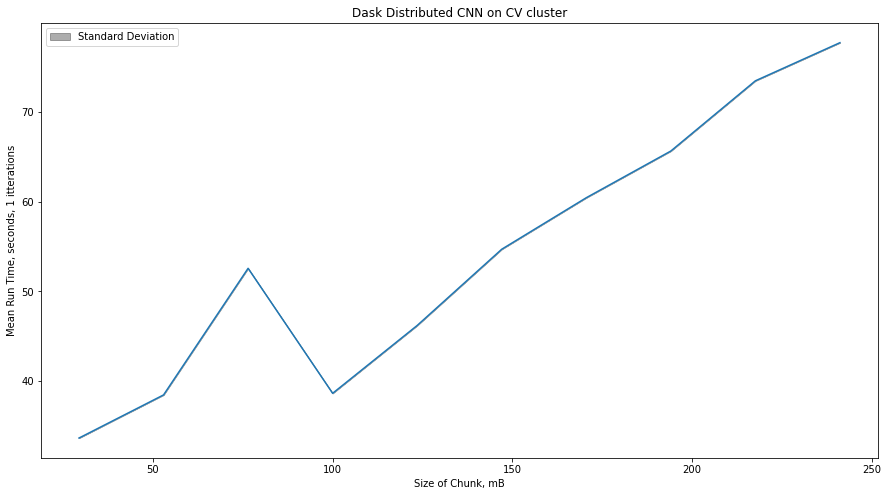

In [115]:
figPrePerf = plt.figure(figsize=(15,8))
chunk_mem = [nim*117612*1E-6 for nim in im_per_chunk]
plt.plot(chunk_mem, times)
plt.fill_between(chunk_mem,times+std,times-std, label='Standard Deviation', color=(0.2,0.2,0.2,0.4))
plt.xlabel('Size of Chunk, mB')
plt.ylabel('Mean Run Time, seconds, '+str(len(itterations))+' itterations')
plt.title('Dask Distributed CNN on CV cluster')
plt.legend()
plt.show()

In [116]:
chunk_mem

[241.10459999999998,
 217.5822,
 194.0598,
 170.5374,
 147.015,
 123.4926,
 99.97019999999999,
 76.4478,
 52.925399999999996,
 29.403]